# IMPORT NECESSARY LIBRARIES AND MODELS




In [2]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import load_files
#commmand line
!pip install stop_words
nltk.download('stopwords')
import pickle

from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ajayc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ajayc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ajayc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ajayc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# LOAD DATASETS

In [3]:
df = pd.read_csv('Emotions_training.csv')
df.head(10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


# Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [5]:
df[df['text'].duplicated() == True]

,text,label
5067,i feel on the verge of tears from weariness i ...,1
6133,i still feel a craving for sweet food,2
6563,i tend to stop breathing when i m feeling stre...,3
7623,i was intensely conscious of how much cash i h...,0
7685,im still not sure why reilly feels the need to...,5
8246,i am not amazing or great at photography but i...,2
9596,ive also made it with both sugar measurements ...,1
9687,i had to choose the sleek and smoother feel of...,1
9769,i often find myself feeling assaulted by a mul...,0
9786,i feel im being generous with that statement,1


In [6]:
index = df[df['text'].duplicated() == True].index
df.drop(index, axis = 0, inplace = True)
df.reset_index(inplace=True, drop = True)

In [7]:
df.shape

(15969, 2)

In [10]:
unique_sentiments = df['label'].unique()
print(unique_sentiments)

[0 3 2 5 4 1]


In [13]:
frequency_counts = df['label'].value_counts()

frequency_percentage = (frequency_counts / len(df['label'])) * 100
frequency_df = pd.DataFrame({'Counts': frequency_counts, 'Percentage': frequency_percentage})

print(frequency_df)

# Print total value
cardinality = df['label'].nunique()
print(f"\ntotal values: {cardinality}")

   Counts  Percentage
1    5350   33.502411
0    4664   29.206588
3    2155   13.494896
4    1933   12.104703
2    1299    8.134511
5     568    3.556891

total values: 6


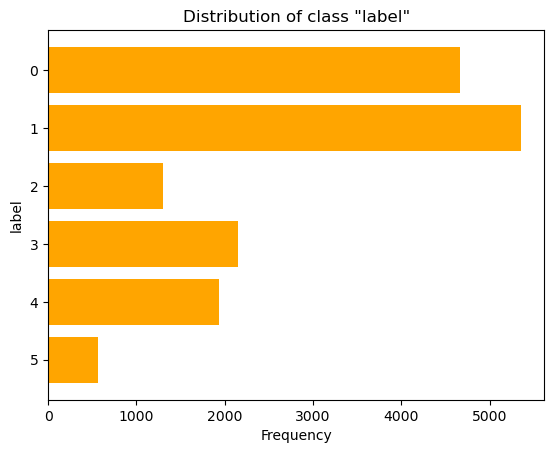

In [8]:
# Extract sentiment values & frequencies  here i have taken senti(like for very happy=1, for sad=3,for very bad=5)
sentiment_counts = df['label'].value_counts().sort_index()

sentiments = sentiment_counts.index
frequencies = sentiment_counts.values

# Plot
plt.barh(sentiments, frequencies, color='orange')
plt.xlabel('Frequency')
plt.ylabel('label')
plt.title('Distribution of class "label"')
plt.gca().invert_yaxis()  
plt.show()

In [9]:
X = df['text']
y = df['label']

print(len(X))
print(len(y))

15969
15969


# [Preprocessing] Data Cleaning

In [10]:
cleaned = []

for sen in range(0, len(X)):
    # Remove all the special characters (any letter or a digit)
    document = re.sub(r'\W', ' ', str(X[sen]))

    # remove all single characters (surrounded by whitespace)
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    # Converting to Lowercase
    document = document.lower()

    # Lemmatization- splits into list of words ['The', 'quick', ....]
    document = document.split()

    lemma = WordNetLemmatizer()
    document = [lemma.lemmatize(word) for word in document]
    document = ' '.join(document)
    cleaned.append(document)

In [11]:
len(cleaned)

15969

# Exploring Cleaned Data & Investigating Stopwords in Text

In [12]:
temp = df.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['text'].apply(lambda x: len(set(x.split()) & stop_words))

# Print rows that contain stopwords
rows_with_stopwords = temp[temp['stop_words'] > 0]
print(rows_with_stopwords)

                                                    text  label  stop_words
0                                i didnt feel humiliated      0           1
1      i can go from feeling so hopeless to so damned...      0          10
2       im grabbing a minute to post i feel greedy wrong      3           3
3      i am ever feeling nostalgic about the fireplac...      2           9
4                                   i am feeling grouchy      3           2
...                                                  ...    ...         ...
15964  i just had a very brief time in the beanbag an...      0          13
15965  i am now turning and i feel pathetic that i am...      0           7
15966                     i feel strong and good overall      1           2
15967  i feel like this was such a rude comment and i...      3           8
15968  i know a lot but i feel so stupid because i ca...      0           8

[15890 rows x 3 columns]


# Tokenisation

In [13]:
cleaned_tokenized = []
for each in cleaned:
    doc = sent_tokenize(each)
    for sentence in doc:
        cleaned_tokenized.append(sentence)

# Type and length of the cleaned & tokenised sentence
print(type(cleaned_tokenized))
print(len(cleaned_tokenized))

# Print the fist 15 lines of the cleaned & tokenised sentence
for i in range(15):
  print(cleaned_tokenized[i])

<class 'list'>
15969
i didnt feel humiliated
i can go from feeling so hopeless to so damned hopeful just from being around someone who care and is awake
im grabbing minute to post feel greedy wrong
i am ever feeling nostalgic about the fireplace will know that it is still on the property
i am feeling grouchy
ive been feeling little burdened lately wasnt sure why that wa
ive been taking or milligram or time recommended amount and ive fallen asleep lot faster but also feel like so funny
i feel a confused about life a teenager or a jaded a year old man
i have been with petronas for year feel that petronas ha performed well and made huge profit
i feel romantic too
i feel like have to make the suffering m seeing mean something
i do feel that running is divine experience and that can expect to have some type of spiritual encounter
i think it the easiest time of year to feel dissatisfied
i feel low energy m just thirsty
i have immense sympathy with the general point but a possible proto write

# [Feature Engineering] Vectorising Using TF-IDF

In [14]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(X)
# CV sparse matrix
freq_term_matrix = count_vectorizer.transform(X)      

tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix) # tf-idf sparse matrix
# print(tf_idf_matrix)
dense_tf_idf_matrix = tf_idf_matrix.toarray()         # tf-idf dense matrix
# print(dense_tf_idf_matrix)

X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, y, test_size=0.2, random_state=42)

# [Model Training/Testing/Evaluation] MNB(multinomial Naive Bayes classifier)

Multinomial Naive Bayes (MNB) is a very popular and efficient machine learning algorithm that is based on Bayes’ theorem. It is commonly used for text classification tasks where we need to deal with discrete data like word counts in documents. 

C:\Users\Ajayc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ajayc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ajayc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ajayc\anaconda3\lib\site-packages\sklearn\metr

Classification Report (Cross-Validation):
               precision    recall  f1-score   support

           0       0.69      0.86      0.77      3694
           1       0.54      0.98      0.70      4321
           2       1.00      0.01      0.01      1007
           3       0.96      0.12      0.22      1756
           4       0.91      0.08      0.15      1548
           5       0.00      0.00      0.00       449

    accuracy                           0.61     12775
   macro avg       0.68      0.34      0.31     12775
weighted avg       0.71      0.61      0.51     12775

Accuracy (Cross-Validation): 0.6100978473581213
Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.71      0.88      0.78       970
           1       0.54      0.98      0.70      1029
           2       1.00      0.01      0.01       292
           3       0.92      0.14      0.24       399
           4       0.87      0.10      0.18       385
     

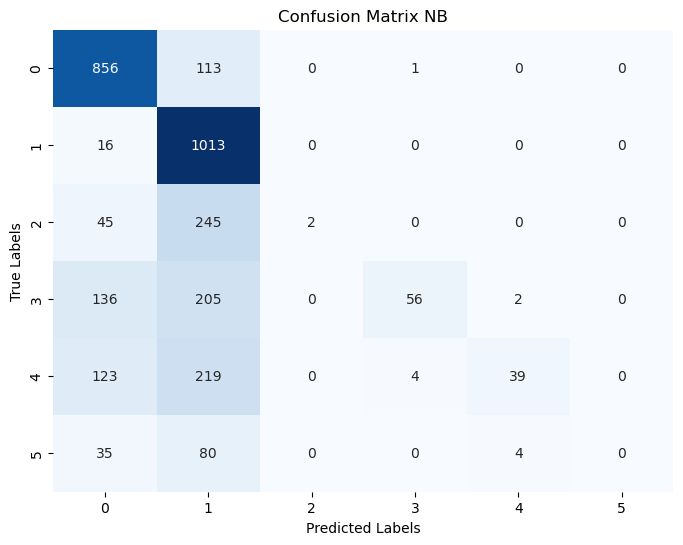

In [15]:
model = MultinomialNB()

# Train
model.fit(X_train, y_train)

# Test
y_pred = model.predict(X_test)

# Evaluate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)

classification_rep = classification_report(y_train, y_pred_cv)
print("Classification Report (Cross-Validation):\n", classification_rep)

accuracy = accuracy_score(y_train, y_pred_cv)
print("Accuracy (Cross-Validation):", accuracy)

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

classification_rep_test = classification_report(y_test, y_pred_test)
print("Classification Report (Test Data):\n", classification_rep_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy (Test Data):", accuracy_test)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculating the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix NB')
plt.show()

# [Model Training/Testing/Evaluation] MLP(Multilayer perceptron)
A multilayer perceptron (MLP) is a name for a modern feedforward artificial neural network 
Consisting of fully connected neurons with a nonlinear kind of activation function, organized in at least three layers notable for being able to distinguish data that is not linearly separable.

Accuracy: 0.8463
Precision: 0.8452
Recall: 0.8463
F1-score: 0.8443


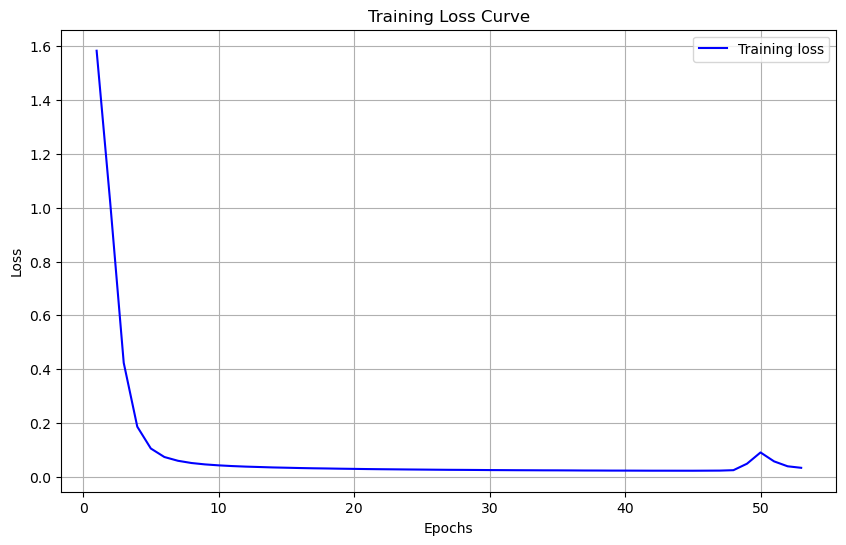

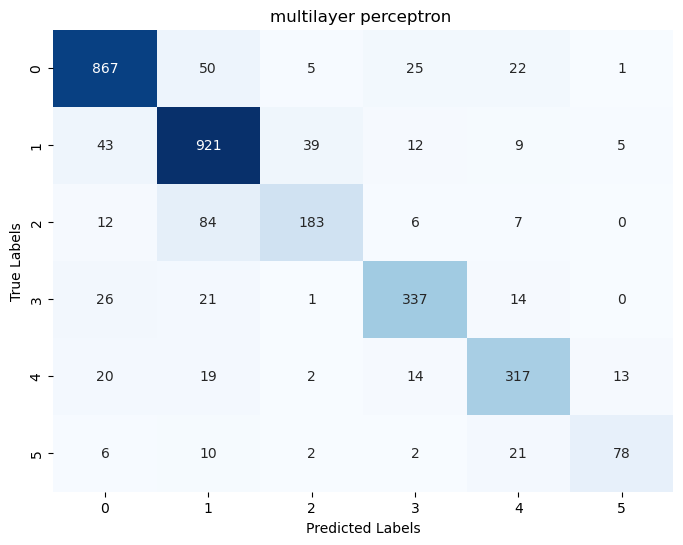

In [19]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100), alpha = 0.01, max_iter=100)

# Train
history = mlp_model.fit(X_train, y_train)

# Test
y_pred = mlp_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

train_loss = history.loss_curve_
num_epochs = len(train_loss)

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
confusion_mat = confusion_matrix(y_test, y_pred)

# Heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('multilayer perceptron ')
plt.show()

# [Model Training/Testing/Evaluation] SVM(Support Vector Machine)
Support Vector Machine (SVM) is a powerful machine learning algorithm used for linear or nonlinear classification, regression, and even outlier detection tasks. 
SVMs can be used for a variety of tasks, such as text classification, image classification, spam detection, handwriting identification, gene expression analysis, face detection, and anomaly detection.

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89       970
           1       0.74      0.97      0.84      1029
           2       0.93      0.43      0.59       292
           3       0.93      0.71      0.80       399
           4       0.81      0.69      0.75       385
           5       0.94      0.39      0.55       119

    accuracy                           0.82      3194
   macro avg       0.87      0.68      0.74      3194
weighted avg       0.83      0.82      0.80      3194

Accuracy: 0.8155917345021916


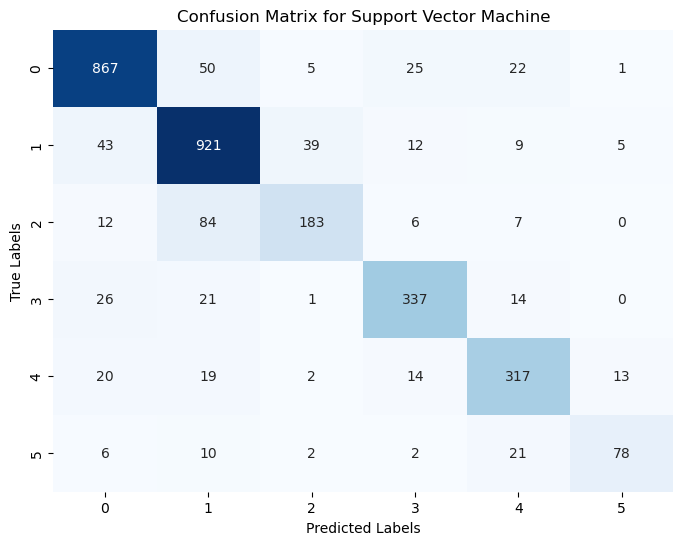

In [20]:
model = SVC()
model.fit(X_train, y_train)

# Test
y_pred = model.predict(X_test)

# Evaluate
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Support Vector Machine')
plt.show()

# Conclusion
Support Vector Machine (SVM) perform the best with the Accuracy: 0.8155917345021916

# future work
Using of various model like BERT [Bidirectional Encoder Representations from Transformers] and XGBoost